In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input/train.csv
./kaggle/input/test.csv
./kaggle/input/sample_solution.csv


In [35]:
path = './kaggle/input/'
trainpath = os.path.join(path,'train.csv')
testpath = os.path.join(path,'test.csv')
samplepath = os.path.join(path,'sample_solution.csv')

df_train = pd.read_csv(trainpath)

In [17]:
df_train.head(5)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [18]:
vc = df_train['claim'].value_counts().to_frame().reset_index()
vc['percent'] = vc["claim"].apply(lambda x : round(100*float(x) / len(df_train), 2))
vc = vc.rename(columns = {"index" : "Target", "claim" : "Count"})
vc

,Target,Count,percent
0,0,480404,50.15
1,1,477515,49.85


In [19]:
df_train[pd.isnull(df_train)].sum()


id       0.0
f1       0.0
f2       0.0
f3       0.0
f4       0.0
        ... 
f115     0.0
f116     0.0
f117     0.0
f118     0.0
claim    0.0
Length: 120, dtype: float64

In [37]:
df_train = df_train.dropna()


In [21]:
vc = df_train['claim'].value_counts().to_frame().reset_index()
vc['percent'] = vc["claim"].apply(lambda x : round(100*float(x) / len(df_train), 2))
vc = vc.rename(columns = {"index" : "Target", "claim" : "Count"})
vc

,Target,Count,percent
0,0,310909,86.49
1,1,48555,13.51


In [24]:
%%time
tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(df_train)

CPU times: user 3h 5min 21s, sys: 13min 46s, total: 3h 19min 8s
Wall time: 1h 13min 43s


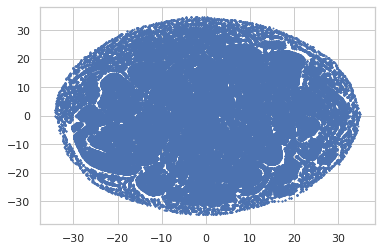

In [26]:
plt.scatter(train_2D[:,0], train_2D[:,1], s = 0.8)

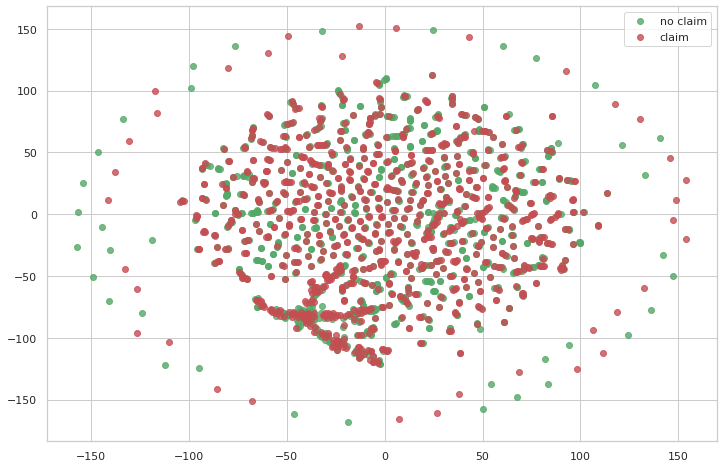

CPU times: user 35.9 s, sys: 280 ms, total: 36.2 s
Wall time: 6.33 s


In [38]:
%%time
no_claim = df_train[df_train['claim'] == 0].sample(1000)
claim = df_train[df_train['claim'] == 1].sample(1000)

df = no_claim.append(claim).sample(frac=1).reset_index(drop=True)
X = df.drop(['claim'], axis = 1).values
Y = df["claim"].values



def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='no claim')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='claim')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [40]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

In [41]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [42]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [43]:
x = df_train.drop(["claim"], axis=1)
y = df_train["claim"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_claim = x_scale[y == 0], x_scale[y == 1]

In [46]:
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0892 - val_loss: 0.0903
Epoch 2/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0879 - val_loss: 0.0892
Epoch 3/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0870 - val_loss: 0.0885
Epoch 4/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0864 - val_loss: 0.0879
Epoch 5/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0859 - val_loss: 0.0875
Epoch 6/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0856 - val_loss: 0.0872
Epoch 7/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0853 - val_loss: 0.0869
Epoch 8/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0851 - val_loss: 0.0867
Epoch 9/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0849 - val_loss: 0.0865
Epoch 10/20
972/972 [==============================] - 3s 3ms/step - loss: 0.0847 - val_loss: 0.0863

In [47]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [48]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_claim)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")